# Test Prioritized Double-DQN

In [286]:
import math
import torch
import torch.nn as nn
from torch.optim import Adam
import gym
import random
import numpy as np

In [287]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [288]:
USE_CUDA = torch.cuda.is_available()
device = 'cuda' if USE_CUDA else 'cpu'
device = torch.device(device)

In [289]:
def plot(frame_idx, rewards, losses):
    %matplotlib inline
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

## Network and Loss Definitions

In [290]:
class QNetwork(nn.Module):
    def __init__(self, input_size, num_actions):
        self.num_actions = num_actions
        super().__init__()
        self.fc = nn.Sequential(nn.Linear(input_size, 128),
                                nn.ReLU(),
                                nn.Linear(128, 128),
                                nn.ReLU(),
                                nn.Linear(128, num_actions))
    def forward(self, x):
        return self.fc(x)
    
    def get_value(self, state):
        return self.forward(state)
    
    def act(self, state, eps):
        if np.random.random() < eps:
            return np.random.randint(self.num_actions)
        return torch.argmax(self.forward(state)).item()

In [291]:
def synchronize_nets(from_net, to_net):
    to_net.load_state_dict(from_net.state_dict())

In [304]:
def ddqn_priority_td_loss(online_net, target_net, batch, memory_size, beta=0.7, gamma=0.95):
    priorities, states, actions, rewards, dones, next_states = map(
        lambda arr: torch.as_tensor(arr, device=device, dtype=torch.float32), 
        batch
    )
    
    state_action_values = torch.gather(
        online_net.get_value(states), 1,
        actions.long().unsqueeze(-1)
    )
    
    online_next_state_values = online_net.get_value(next_states)
    best_online_actions = torch.argmax(online_next_state_values, dim=1)

    target_next_state_values = target_net.get_value(next_states)
    
    target_state_action_values = torch.gather(
        target_next_state_values, 1, 
        best_online_actions.unsqueeze(-1)
    )
    target_state_action_values *= 1.0 - dones.float().unsqueeze(-1)
    
    expected_state_action_values = rewards.unsqueeze(-1) + gamma * target_state_action_values
    
    
    td_error = expected_state_action_values - state_action_values
    
    imp_samp_weights = (1/memory_size) * (1/priorities)
    imp_samp_weights /= torch.max(imp_samp_weights)
    imp_samp_weights = torch.pow(imp_samp_weights, beta)
    loss = (td_error).pow(2).mean()
    
    return td_error, loss

In [293]:
from crar.experience import PrioritizedReplayBuffer, TDExperience
from crar.utils import compute_eps

def play_step(replay_buffer, state, qnet, env, step_number, 
              eps_start=1.0, eps_end=0.01, eps_last_frame=1000):
    eps = compute_eps(step_number, eps_start, eps_end, eps_last_frame)
    action = qnet.act(
        torch.as_tensor(np.expand_dims(state, 0), device=device).float(),
        eps
    )
    next_state, reward, done, _ = env.step(action)
    # States that are experienced for the first time have highest priority
    exp = TDExperience([-1e5, state, action, reward, done, next_state])
    replay_buffer.push(exp)
    
    return next_state, reward, done

In [294]:
def populate_warm_start(replay_buffer, qnet, env, eps_start=1.0, 
                        eps_end=0.001, eps_last_frame=1000):
    state = env.reset()
    for _ in range(1000):
        next_state, reward, done =\
            play_step(replay_buffer, state, qnet, env, 0)
        state = next_state
        if done:
            state = env.reset()

## CartPole

In [295]:
online_net = QNetwork(4, 2).to(device)
target_net = QNetwork(4, 2).to(device)

In [296]:
REPLAY_SIZE = 500
MAX_EP_LEN = 200
BATCH_SIZE = 32
SYNC_INTERVAL = 50
PLOT_INTERVAL = 100
TOTAL_STEPS = 2000
GRAD_CLIP = 10.0

In [297]:
replay_buffer = PrioritizedReplayBuffer(REPLAY_SIZE, sort_interval=64)

In [298]:
from crar.environments import TimeLimit

env_id = "CartPole-v0"
env = gym.make(env_id)
env = TimeLimit(env, MAX_EP_LEN)

In [299]:
populate_warm_start(replay_buffer, online_net, env)    

In [300]:
replay_buffer.sample(BATCH_SIZE)

(array([-100000., -100000., -100000., -100000., -100000., -100000.,
        -100000., -100000., -100000., -100000., -100000., -100000.,
        -100000., -100000., -100000., -100000., -100000., -100000.,
        -100000., -100000., -100000., -100000., -100000., -100000.,
        -100000., -100000., -100000., -100000., -100000., -100000.,
        -100000., -100000.]),
 array([[ 1.73508499e-02,  4.60230456e-02,  2.18614233e-02,
         -3.15847012e-02],
        [-5.79269227e-02, -3.03079943e-02,  4.59037749e-03,
         -1.18567524e-01],
        [ 2.27409773e-02, -2.44475046e-01, -6.09690820e-03,
          2.92625956e-01],
        [ 1.82713108e-02,  2.40824782e-01,  2.12297293e-02,
         -3.17290737e-01],
        [ 9.82479743e-03, -1.51886082e-01,  4.40187455e-02,
          3.22858717e-01],
        [ 2.30878065e-02,  4.54069855e-02,  1.48839146e-02,
         -1.79890245e-02],
        [ 2.03279671e-02, -1.48855858e-01,  1.67460320e-02,
          2.55769565e-01],
        [ 1.67557490e

In [301]:
optimizer = torch.optim.Adam(online_net.parameters(), lr=5e-4)

In [302]:
def train_loop():
    state = env.reset()
    ep_rewards_list = []
    losses_list = []
    episode_reward = 0
    state = env.reset()
    for step_num in range(1, TOTAL_STEPS + 1):
        if len(replay_buffer) > BATCH_SIZE:
            batch = replay_buffer.sample(BATCH_SIZE)
            td_error, loss = ddqn_priority_td_loss(online_net, target_net, batch, len(replay_buffer))
            replay_buffer.update_priorities(td_error)
            losses_list.append(loss)
            optimizer.zero_grad()
            loss.backward()
            if GRAD_CLIP > 0:
                nn.utils.clip_grad_norm_(online_net.parameters(), GRAD_CLIP)
            optimizer.step()
        
        if step_num % SYNC_INTERVAL == 0:
            synchronize_nets(online_net, target_net)
        
        next_state, reward, done =\
            play_step(replay_buffer, state, online_net, env, step_num)
        episode_reward += reward
        state = next_state
        if done:
            ep_rewards_list.append(episode_reward)
            episode_reward = 0
            state = env.reset()
        if step_num % PLOT_INTERVAL == 0:
            plot(step_num, ep_rewards_list, losses_list)    
            

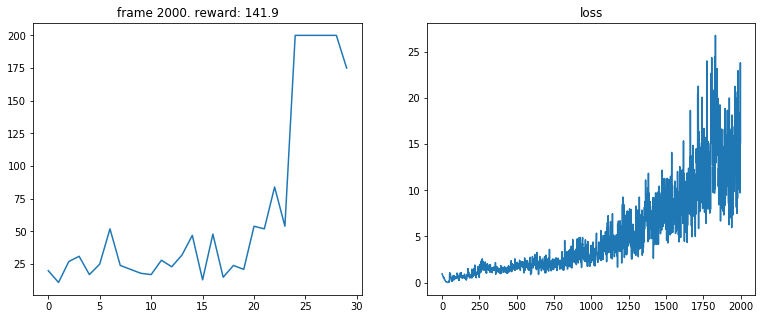

In [303]:
train_loop()